# Ensembles notebook

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/ensembles.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the simple examples of using the ensemble models with ETNA library.

**Table of Contents**

* [Load Dataset](#chapter1)  
* [Build Pipelines](#chapter2)
* [Ensembles](#chapter3)
    * [VotingEnsemble](#section_3_1)
    * [StackingEnsamble](#section_3_2)
    * [Results](#section_3_3)

In [1]:
import warnings

warnings.filterwarnings("ignore")

## 1. Load Dataset <a class="anchor" id="chapter1"></a>

In this notebook we will work with the dataset contains only one segment with monthly wine sales. Working process with the dataset containing more segments will be absolutely the same.

In [2]:
import pandas as pd
from etna.datasets import TSDataset

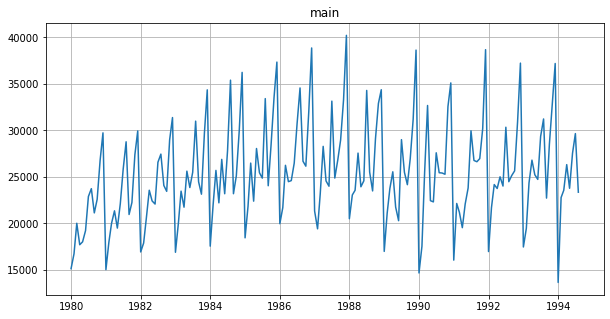

In [3]:
original_df = pd.read_csv("data/monthly-australian-wine-sales.csv")
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df=df, freq="MS")
ts.plot()

## 2. Build Pipelines <a class="anchor" id="chapter2"></a>

Given the sales' history, we want to select the best model(pipeline) to forecast future sales.

In [4]:
from etna.pipeline import Pipeline
from etna.models import (
    NaiveModel,
    SeasonalMovingAverageModel,
    CatBoostModelMultiSegment,
)
from etna.transforms import LagTransform
from etna.metrics import MAE, MSE, SMAPE, MAPE

HORIZON = 3
N_FOLDS = 5

Let's build four pipelines using the different models

In [5]:
naive_pipeline = Pipeline(model=NaiveModel(lag=12), transforms=[], horizon=HORIZON)
seasonalma_pipeline = Pipeline(
    model=SeasonalMovingAverageModel(window=5, seasonality=12),
    transforms=[],
    horizon=HORIZON,
)
catboost_pipeline = Pipeline(
    model=CatBoostModelMultiSegment(),
    transforms=[LagTransform(lags=[6, 7, 8, 9, 10, 11, 12], in_column="target")],
    horizon=HORIZON,
)
pipeline_names = ["naive", "moving average", "catboost"]
pipelines = [naive_pipeline, seasonalma_pipeline, catboost_pipeline]

And evaluate their performance on the backtest

In [6]:
metrics = []
for pipeline in pipelines:
    metrics.append(
        pipeline.backtest(
            ts=ts,
            metrics=[MAE(), MSE(), SMAPE(), MAPE()],
            n_folds=N_FOLDS,
            aggregate_metrics=True,
            n_jobs=5,
        )[0].iloc[:, 1:]
    )
metrics = pd.concat(metrics)
metrics.index = pipeline_names
metrics

[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   12.0s remaining:   17.9s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   17.0s remaining:   11.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   26.2s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.6s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:   16.5s remaining:   11.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   28.1s finished
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.


,MAE,MSE,SMAPE,MAPE
naive,2437.466667,1.089199e+07,9.949886,10.222106
moving average,1913.826667,6.113701e+06,7.897570,7.824056
catboost,2271.766726,8.923741e+06,9.376638,10.013138


## 3. Ensembles <a class="anchor" id="chapter3"></a>
To improve the performance of the individual models, we can try to make ensembles out of them. Our library contains two ensembling methods, which we will try on now.

### 3.1 VotingEnsemble<a class="anchor" id="section_3_1"></a>

`VotingEnsemble` forecasts future values with weighted averaging of it's `pipelines` forecasts.

In [7]:
from etna.ensembles import VotingEnsemble

By default, `VotingEnsemble` uses **uniform** weights for the pipelines' forecasts. However, you can specify the weights manually using the `weights` parameter. The higher weight the more you trust the base model. 

*Note*: The `weights` are automatically normalized.

In [8]:
voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=[1, 9, 4], n_jobs=4)

In [9]:
voting_ensamble_metrics = voting_ensemble.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]
voting_ensamble_metrics.index = ["voting ensemble"]
voting_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   11.7s remaining:    7.8s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   12.8s finished
/Users/d.a.binin/Library/Caches/pypoetry/virtualenvs/etna-5hbqKzTr-py3.8/lib/python3.8/site-packages/joblib/parallel.py:735: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   3 out of   

,MAE,MSE,SMAPE,MAPE
voting ensemble,1972.207943,6.685831e+06,8.172377,8.299714


### 3.2 StackingEnsemble<a class="anchor" id="section_3_2"></a>
`StackingEnsemble` forecasts future using the metamodel to combine the forecasts of it's `pipelines`.

In [10]:
from etna.ensembles import StackingEnsemble

By default, `StackingEnsemble` uses only the pipelines' forecasts as features for the `final_model`. However, you can specify the additional features using the `features_to_use` parameter. The following values are possible:
+ **None** - use only the pipelines' forecasts(default)
+ **List[str]** - use the pipelines' forecasts + features from the list
+ **"all"** - use all the available features

*Note:* It is possible to use only the features available for the base models.

In [11]:
stacking_ensemble_unfeatured = StackingEnsemble(pipelines=pipelines, n_folds=10, n_jobs=4)

In [12]:
stacking_ensamble_metrics = stacking_ensemble_unfeatured.backtest(
    ts=ts,
    metrics=[MAE(), MSE(), SMAPE(), MAPE()],
    n_folds=N_FOLDS,
    aggregate_metrics=True,
    n_jobs=2,
)[0].iloc[:, 1:]
stacking_ensamble_metrics.index = ["stacking ensemble"]
stacking_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   22.5s
[Parallel(n_jobs=2)]: Done   3 out of   5 | elapsed:   25.7s remaining:   17.1s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   36.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   36.4s finished
/Users/d.a.binin/Library/Caches/pypoetry/virtualenvs/etna-5hbqKzTr-py3.8/lib/python3.8/site-packages/joblib/parallel.py:735: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of  

,MAE,MSE,SMAPE,MAPE
stacking ensemble,2058.487868,8.182131e+06,8.508705,8.50082


In addition, it is also possible to specify the `final_model`. You can use any regression model with the sklearn interface for this purpose.

### 3.3 Results<a class="anchor" id="section_3_3"></a>
Finally, let's take a look at the results of our experiments

In [13]:
metrics = pd.concat([metrics, voting_ensamble_metrics, stacking_ensamble_metrics])
metrics

,MAE,MSE,SMAPE,MAPE
naive,2437.466667,1.089199e+07,9.949886,10.222106
moving average,1913.826667,6.113701e+06,7.897570,7.824056
catboost,2271.766726,8.923741e+06,9.376638,10.013138
voting ensemble,1972.207943,6.685831e+06,8.172377,8.299714
stacking ensemble,2058.487868,8.182131e+06,8.508705,8.500820
